## Import Library

In [1]:
import shutil
import os

src_root = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
dst_root = '/kaggle/working/Dataset_BUSI_cleaned'

if not os.path.exists(dst_root):
    shutil.copytree(src_root, dst_root)
    print('copied')


copied


In [ ]:
import os
from PIL import Image
import imagehash
import matplotlib.pyplot as plt
from itertools import combinations

def get_image_phash(image_path):
    with Image.open(image_path) as img:
        return imagehash.phash(img)

def overlay_mask(image_path,mask_path,alpha=0.4):
    img=Image.open(image_path).convert('RGB')
    if os.path.exists(mask_path):
        mask=Image.open(mask_path).convert('L')
        mask_colored=Image.new('RGBA',img.size,(255,0,0,0))
        mask_colored.putalpha(mask.point(lambda p:int(p>0)*int(255*alpha)))
        img=img.convert('RGBA')
        img=Image.alpha_composite(img,mask_colored)
    return img

def find_and_display_near_duplicates(root,threshold=5):
    duplicates_all={}
    subfolders=['benign','malignant','normal']
    for sub in subfolders:
        folder_path=os.path.join(root,sub)
        images=sorted([f for f in os.listdir(folder_path) if f.endswith('.png') and not f.endswith('_mask.png')])
        hashes={img:get_image_phash(os.path.join(folder_path,img)) for img in images}
        compared=set()
        duplicates_all[sub]=[]
        print(f"Near duplicates in {sub}:")
        for base_img in images:
            related=[pair for pair in images if pair!=base_img and hashes[base_img]-hashes[pair]<=threshold]
            if not related or base_img in compared:
                continue
            compared.update(related+[base_img])
            duplicates_all[sub].append([base_img]+related)
            n=len(related)+1
            fig,axes=plt.subplots(1,n,figsize=(4*n,4))
            if n==1:
                axes=[axes]
            base_img_path=os.path.join(folder_path,base_img)
            base_mask_path=base_img_path.replace('.png','_mask.png')
            axes[0].imshow(overlay_mask(base_img_path,base_mask_path))
            axes[0].set_title(base_img)
            axes[0].axis('off')
            for i,img_name in enumerate(related,1):
                img_path=os.path.join(folder_path,img_name)
                mask_path=img_path.replace('.png','_mask.png')
                axes[i].imshow(overlay_mask(img_path,mask_path))
                axes[i].set_title(img_name)
                axes[i].axis('off')
            plt.tight_layout()
            plt.show()
    return duplicates_all

# Example usage
root=dst_root
duplicates=find_and_display_near_duplicates(root,threshold=9)
print(duplicates)


In [3]:
keep_dict = {
    "benign": [318, 10, 156, 11, 329, 37, 30, 129, 13, 131, 38, 133, 134, 58, 136, 138, 139, 14, 15, 150, 151, 152, 25, 86, 164, 17, 35, 197, 199, 2, 290, 301, 289, 282, 262, 206, 256, 291, 209, 298, 211, 253, 260, 270, 216, 217, 218, 272, 257, 292, 278, 250, 228, 259, 230, 295, 276, 299, 261, 294, 236, 238, 258, 277, 266, 251, 284, 3, 307, 422, 423, 312, 426, 4, 322, 6, 324, 8, 395, 396, 412, 415, 94, 222, 158, 122, 33, 96, 302, 220, 246, 224, 264, 288, 305, 424, 9, 108, 21],
    "malignant": [10, 109, 110, 114, 18, 119, 88, 4, 8, 96, 34, 8, 42],
    "normal": [104, 119, 121, 122, 123, 124, 125, 28, 32, 128, 35, 5, 26, 19, 64, 50, 56, 40, 61, 42, 54, 67, 68, 60, 98, 20, 81, 68],
}


# keep_dict = {
#     'benign':[158,
# 122,
# 33,
# 96,
# 302,
# 220,
# 246,
# 224,
# 264,
# 288,
# 305,
# 424,
# 9,
# ],
#     'malignant':[15,
# 34,
# 8,
# ],
#     'normal':[33,
# 20,
# 81,
# 68,
# ]
# }

# keep_dict = {
#     'benign':[108,21],
#     'malignant':[42],
#     'normal':[]
# }

def clean_duplicates(duplicates, root, keep_dict):
    """
    duplicates: dict from previous output, keys=subfolders, values=list of lists of filenames
    keep_dict: dict, keys=subfolders, values=list of indexes to keep
    root: dataset root folder
    """
    for category, groups in duplicates.items():
        keep_indices = set(keep_dict.get(category,[]))
        folder_path = os.path.join(root, category)
        for group in groups:
            for fname in group:
                idx = int(fname.split('(')[1].split(')')[0])
                if idx not in keep_indices:
                    fpath = os.path.join(folder_path,fname)
                    mask_path = fpath.replace('.png','_mask.png')
                    if os.path.exists(fpath):
                        os.remove(fpath)
                    if os.path.exists(mask_path):
                        os.remove(mask_path)

# Usage example
root=dst_root
clean_duplicates(duplicates, root, keep_dict)


In [4]:
# folder_path='/kaggle/working/Dataset_BUSI_cleaned/benign'
# image_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff', '.webp')

# image_count = 0
# for filename in os.listdir(folder_path):
#     if filename.lower().endswith(image_extensions):
#         image_count += 1

# print(f"Number of images: {image_count}")

In [5]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [6]:
# !kaggle kernels output edenkoresh/breast-cancer-ultrasound-segmentation-segformer -p /path/to/dest

In [7]:
# !pip install transformers

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
import glob
import shutil
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torch.utils.tensorboard import SummaryWriter

import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import get_cosine_schedule_with_warmup
from transformers import SegformerForSemanticSegmentation

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [9]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"


In [10]:
do_train = False

## Class Dataset

In [11]:
class BreastCancerDataset(Dataset):
    def __init__(self, paths, transform=None, augment_classes=["malignant","normal"],
                 dup_factor=2, mode="train"):
        """
        paths: list of mask paths
        transform: Albumentations transform (for training)
        augment_classes: classes to duplicate when training
        dup_factor: duplication factor for augment_classes
        mode: 'train' or 'test'
        """
        self.paths=paths
        self.transform=transform
        self.augment_classes=augment_classes or []
        self.dup_factor=dup_factor
        self.mode=mode
        self.labels=[os.path.basename(os.path.dirname(p)) for p in paths]

    def __len__(self):
        if self.mode=="test":
            return len(self.paths)  # no enlargement in test mode
        n=0
        for lbl in self.labels:
            if lbl in self.augment_classes:
                n+=self.dup_factor
            else:
                n+=1
        return n
        
    def __getitem__(self, index):
        # Map back to real index
        if self.mode=="test":
            real_idx=index
        else:
            counter=0
            for real_idx,lbl in enumerate(self.labels):
                reps=self.dup_factor if lbl in self.augment_classes else 1
                if index<counter+reps:
                    break
                counter+=reps
            lbl=self.labels[real_idx]

        path=self.paths[real_idx]
        image=cv2.imread(path.replace("_mask.png",".png"))
        mask=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        mask[mask==255]=1

        if self.mode=="train":
            # Decide original vs augmented
            if self.transform and (lbl in self.augment_classes) and (index!=counter):
                transformed=self.transform(image=image,mask=mask)
            else:
                transformed=test_transform(image=image,mask=mask)
        else:  # test mode always uses test_transform
            transformed=test_transform(image=image,mask=mask)

        image,mask=transformed["image"],transformed["mask"]
        return image.float(),mask.float(),self.labels[real_idx]


In [12]:
size = 512
train_transform = A.Compose([
    A.Resize(size, size),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.Affine(shear=15, translate_percent=0.05, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Perspective(scale=(0.15, 0.15),p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])
    # A.RandomRotate90(),
    # A.GaussianBlur(),
    # A.ElasticTransform(alpha=1.0),

test_transform = A.Compose([
    A.Resize(size, size),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])

## UnNormalized

In [13]:
class UnNormalized(object):
    def __init__(self, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unNorm = UnNormalized()

In [14]:
root='/kaggle/working/Dataset_BUSI_cleaned'
all_paths = glob.glob(f"{root}/*/*_mask.png")
labels = [p.split("/")[-2] for p in all_paths]

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_paths, labels, test_size=0.30, random_state=159, stratify=labels
)

val_paths, test_paths, _, _ = train_test_split(
    temp_paths, temp_labels, test_size=0.50, random_state=159, stratify=temp_labels
)

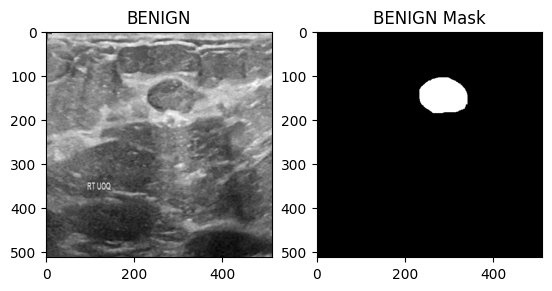

In [15]:
train_dataset = BreastCancerDataset(paths=train_paths, transform=train_transform, mode="train")
val_dataset = BreastCancerDataset(paths=val_paths, transform=test_transform, mode="test")
test_dataset = BreastCancerDataset(paths=test_paths, transform=test_transform, mode="test")

image, mask, label = train_dataset[random.randint(1, len(train_dataset))]
plt.subplot(1, 2, 1)
plt.imshow(unNorm(image).permute(1, 2, 0))
plt.title(label.upper())

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title(f'{label.upper()} Mask')
plt.show()

In [16]:
from collections import Counter

counts=Counter()
for lbl in train_dataset.labels:
    reps=train_dataset.dup_factor if lbl in train_dataset.augment_classes else 1
    counts[lbl]+=reps

print(counts)

Counter({'malignant': 270, 'benign': 227, 'normal': 130})


## AverageMeter

In [17]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n = 1):
        self.val += val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Show Loss

In [18]:
def plot_segmentation_metrics(train_loss, val_loss, train_mean_iou=None, val_mean_iou=None, 
                              train_dice_score=None, val_dice_score=None):
    """
    Plot training and validation metrics (loss, mean IoU, Dice score) over epochs.

    Args:
    - train_loss (list): List of training loss values over epochs.
    - val_loss (list): List of validation loss values over epochs.
    - train_mean_iou (list, optional): List of training mean IoU values over epochs.
    - val_mean_iou (list, optional): List of validation mean IoU values over epochs.
    - train_dice_score (list, optional): List of training Dice score values over epochs.
    - val_dice_score (list, optional): List of validation Dice score values over epochs.
    """
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(15, 10))
    
    # Plotting the Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Val Loss')
    plt.title('Training and Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plotting the Mean IoU (if available)
    if train_mean_iou:
        plt.subplot(2, 2, 2)
        plt.plot(epochs, train_mean_iou, 'r', label='Training Mean IoU')
    if val_mean_iou:
        plt.subplot(2, 2, 2)
        plt.plot(epochs, val_mean_iou, 'b', label='Val Mean IoU')
        plt.title('Training and Val Mean IoU')
        plt.xlabel('Epochs')
        plt.ylabel('Mean IoU')
        plt.legend()
    
    # Plotting the Dice Score (if available)
    if train_dice_score:
        plt.subplot(2, 2, 3)
        plt.plot(epochs, train_dice_score, 'r', label='Training Dice Score')
    if val_dice_score:
        plt.subplot(2, 2, 3)
        plt.plot(epochs, val_dice_score, 'b', label='Val Dice Score')
        plt.title('Training and Val Dice Score')
        plt.xlabel('Epochs')
        plt.ylabel('Dice Score')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

## Calculate Intersection And Union

In [19]:
def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    # 'K' classes, output and target sizes are N or N * L or N * H * W, each value in range 0 to K - 1.
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target

## Train

In [20]:
upsample = nn.Upsample(scale_factor=4, mode='bilinear')

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [22]:
def train(train_dataset, val_dataset, num_class, n_workers, batch_size, lr, epochs, checkpoint, saved_model):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # train_dataset = BreastCancerDataset(transform=train_transform)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=n_workers
    )
    
    # val_dataset = BreastCancerDataset(is_train=False, transform=test_transform)
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        num_workers=n_workers
    )

    version = "nvidia/segformer-b3-finetuned-ade-512-512"
    model = SegformerForSemanticSegmentation.from_pretrained(version)
    
    in_channels = model.decode_head.classifier.in_channels
    model.decode_head.classifier = nn.Conv2d(in_channels, num_class, 1, 1)
    model.to(device)
    
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr, weight_decay=1e-4)
    
    num_batch = len(train_loader)
    
    scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=num_batch*epochs, power=0.9)

    if os.path.isdir(checkpoint):
        shutil.rmtree(checkpoint)
    os.makedirs(checkpoint)
    
    if not os.path.isdir(saved_model):
        os.makedirs(saved_model)
    
    writer = SummaryWriter(checkpoint)
    
    train_loss = []
    val_loss = []
    val_mIoU = []
    val_mDice = []
    intersection_meter = AverageMeter()
    union_meter = AverageMeter()
    train_loss_meter = AverageMeter()
    val_loss_meter = AverageMeter()
    
    no_improvement_counter = 0
    patience = 5
    best_mIoU = -1
    
    for epoch in range(epochs):
        model.train()
        train_loss_meter.reset()
        val_loss_meter.reset()
        intersection_meter.reset()
        union_meter.reset()
        
        progress_bar = tqdm(train_loader, colour='cyan')
        
        for i, (image, mask, __) in enumerate(progress_bar):
            image, mask = image.to(device), mask.to(device)
            
            output = model(image).logits
            output = upsample(output).squeeze()
            loss = criterion(output, mask)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss_meter.update(loss.item())
            progress_bar.set_description(f"Train | Epoch {epoch + 1}/{epochs} | Loss {train_loss_meter.avg:.4f} | lr {optimizer.param_groups[0]['lr']}")
            writer.add_scalar("Train/Loss AVG", train_loss_meter.avg, num_batch * epoch + i)
            writer.add_scalar("Train/Loss", loss.item(), num_batch * epoch + i)
            scheduler.step()
        
        model.eval()
        with torch.no_grad():
            progress_bar = tqdm(iterable=val_loader, colour='yellow')
            
            for image, mask, _ in progress_bar:
                image, mask = image.to(device), mask.to(device)
                
                output = model(image).logits
                output = upsample(output).squeeze()
                loss = criterion(output, mask)
                
                val_loss_meter.update(loss.item())
                output[output>=0.5] = 1
                output[output<0.5] = 0
                output = output.long()
                mask = mask.long()
                
                intersection, union, target = intersectionAndUnionGPU(output, mask, 2)           
                intersection_meter.update(intersection)
                union_meter.update(union)
                
                iou = intersection / (union + 1e-10)
                mean_iou = np.mean(iou.cpu().numpy())
                dice = 2 * intersection / (intersection + union + 1e-10)

                dice_value = dice.mean().item()
                
                intersection_meter.update(intersection)
                union_meter.update(union)
                val_loss_meter.update(loss.item())
                
                progress_bar.set_description(f"Val | Loss {loss.item():.4f} | mIoU: {mean_iou:.4f} | dice: {dice_value:.4f}")
            
            
            iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)
            dice_class = 2 * intersection_meter.sum / (intersection_meter.sum + union_meter.sum + 1e-10)
            
            mIoU = iou_class.mean().item()
            mDice = dice_class.mean().item()
            print(f"Val | Loss {val_loss_meter.avg:.4f} | mIoU: {mIoU:.4f} | dice: {mDice:.4f}")
            
            writer.add_scalar("Val/Loss", val_loss_meter.avg, epoch)
            writer.add_scalar("Val/mIoU", mIoU, epoch)
            writer.add_scalar("Val/dice", mDice, epoch)
            
            checkpoint_data = {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch + 1,
                "mIoU": mIoU,
                "mDice": mDice
            }
            
            torch.save(checkpoint_data, os.path.join(saved_model, "last.pt"))
            
            if mIoU > best_mIoU:
                best_mIoU = mIoU
                torch.save(checkpoint_data, os.path.join(saved_model, "best.pt"))
                no_improvement_counter = 0
            else:
                no_improvement_counter += 1
              
            train_loss.append(train_loss_meter.avg)
            val_loss.append(val_loss_meter.avg)
            val_mIoU.append(mIoU)
            val_mDice.append(mDice)
            
            if no_improvement_counter > patience:
                print("Early stopping!")
                break
    
    plot_segmentation_metrics(train_loss, val_loss, None, val_mIoU, None, val_mDice)


In [23]:
import gc

for _ in range(3):
    torch.cuda.empty_cache()
    
    gc.collect()

In [24]:
num_class = 1
n_workers = int(os.cpu_count())
# print(n_workers)
batch_size = 8
lr = 1e-4
epochs = 50
checkpoint = "/kaggle/working/tensorboard"
saved_model = "/kaggle/working/saved_model"

In [25]:
if do_train:
    train(train_dataset, val_dataset, num_class, n_workers, batch_size, lr, epochs, checkpoint, saved_model)

## Inference

In [26]:
def pred_show_best_worst_per_label(model_pth, device, test_dataset, num_class, top_k=4):
    # Load model checkpoint
    checkpoint = torch.load(model_pth, map_location=device)
    
    # Initialize and load model state
    model_name = "nvidia/segformer-b3-finetuned-ade-512-512"
    model = SegformerForSemanticSegmentation.from_pretrained(model_name)
    in_channels = model.decode_head.classifier.in_channels
    model.decode_head.classifier = nn.Conv2d(in_channels, num_class, 1, 1)
    model.to(device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Dict to store per-category results
    results_by_label = {label: [] for label in test_dataset.labels}

    with torch.no_grad():
        for idx in range(len(test_dataset)):
            ori_img, orig_mask, label = test_dataset[idx]
            img = ori_img.float().to(device).unsqueeze(0)

            # Get logits and prob map
            logits = model(img).logits
            prob_mask = torch.sigmoid(upsample(logits)).squeeze().cpu().numpy()  # shape (H,W)
            pred_mask = (prob_mask >= 0.5).astype(np.uint8)
            
            # Predict mask
            pred_mask = upsample(model(img).logits).squeeze()
            pred_mask[pred_mask>=0.5] = 1
            pred_mask[pred_mask<0.5] = 0
            pred_mask = pred_mask.long()

            # Compute IoU
            intersection, union, _ = intersectionAndUnionGPU(pred_mask, orig_mask.long().to(device), K=num_class)
            iou = (intersection / (union + 1e-10)).mean().item()

            # Infer label from file path
            # path = test_dataset.path[idx]
            # label = os.path.basename(os.path.dirname(path))  # e.g., benign/malignant/normal

            # Reconstruct RGB image
            img_np = unNorm(ori_img).permute(1,2,0).numpy()  # shape (H,W,3), float in [0,1]
            img_uint8 = (img_np * 255).astype(np.uint8)

            # Generate heatmap
            heatmap = cv2.applyColorMap((prob_mask*255).astype(np.uint8), cv2.COLORMAP_JET)
            heatmap_overlay = cv2.addWeighted(img_uint8, 0.6, heatmap, 0.4, 0)

            results_by_label[label].append((
                idx, iou, img_uint8, orig_mask.numpy(), pred_mask.cpu().numpy(), heatmap_overlay
            ))

            # results_by_label[label].append((
            #     idx,
            #     iou,
            #     unNorm(ori_img).permute(1,2,0),
            #     orig_mask.numpy(),
            #     pred_mask.cpu().numpy()
            # ))

    # Plot best and worst per category
    for label, results in results_by_label.items():
        if not results:
            continue
        results.sort(key=lambda x: x[1])  # sort by IoU

        worst_samples = results[:top_k]
        best_samples = results[-top_k:]

        display_samples = worst_samples + best_samples

        fig = plt.figure(figsize=(24, 12))
        fig.suptitle(f"{label.upper()} - {top_k} Worst and {top_k} Best Predictions", fontsize=16)

        for i, (idx, iou, img, gt, pred, heatmap_overlay) in enumerate(display_samples, 1):
            fig.add_subplot(4, len(display_samples), i)
            plt.imshow(img)
            plt.title(f"Image {idx}\nIoU={iou:.4f}")
            plt.axis("off")

            fig.add_subplot(4, len(display_samples), i + len(display_samples))
            plt.imshow(gt, cmap="gray")
            plt.title("Ground Truth")
            plt.axis("off")

            fig.add_subplot(4, len(display_samples), i + 2*len(display_samples))
            plt.imshow(pred, cmap="gray")
            plt.title("Prediction")
            plt.axis("off")

            fig.add_subplot(4, len(display_samples), i + 3*len(display_samples))
            plt.imshow(heatmap_overlay)
            plt.title("Heatmap Overlay")
            plt.axis("off")

        plt.tight_layout()
        plt.show()


/tmp/ipykernel_30/3727912990.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_pth, map_location=device)


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/190M [00:00<?, ?B/s]

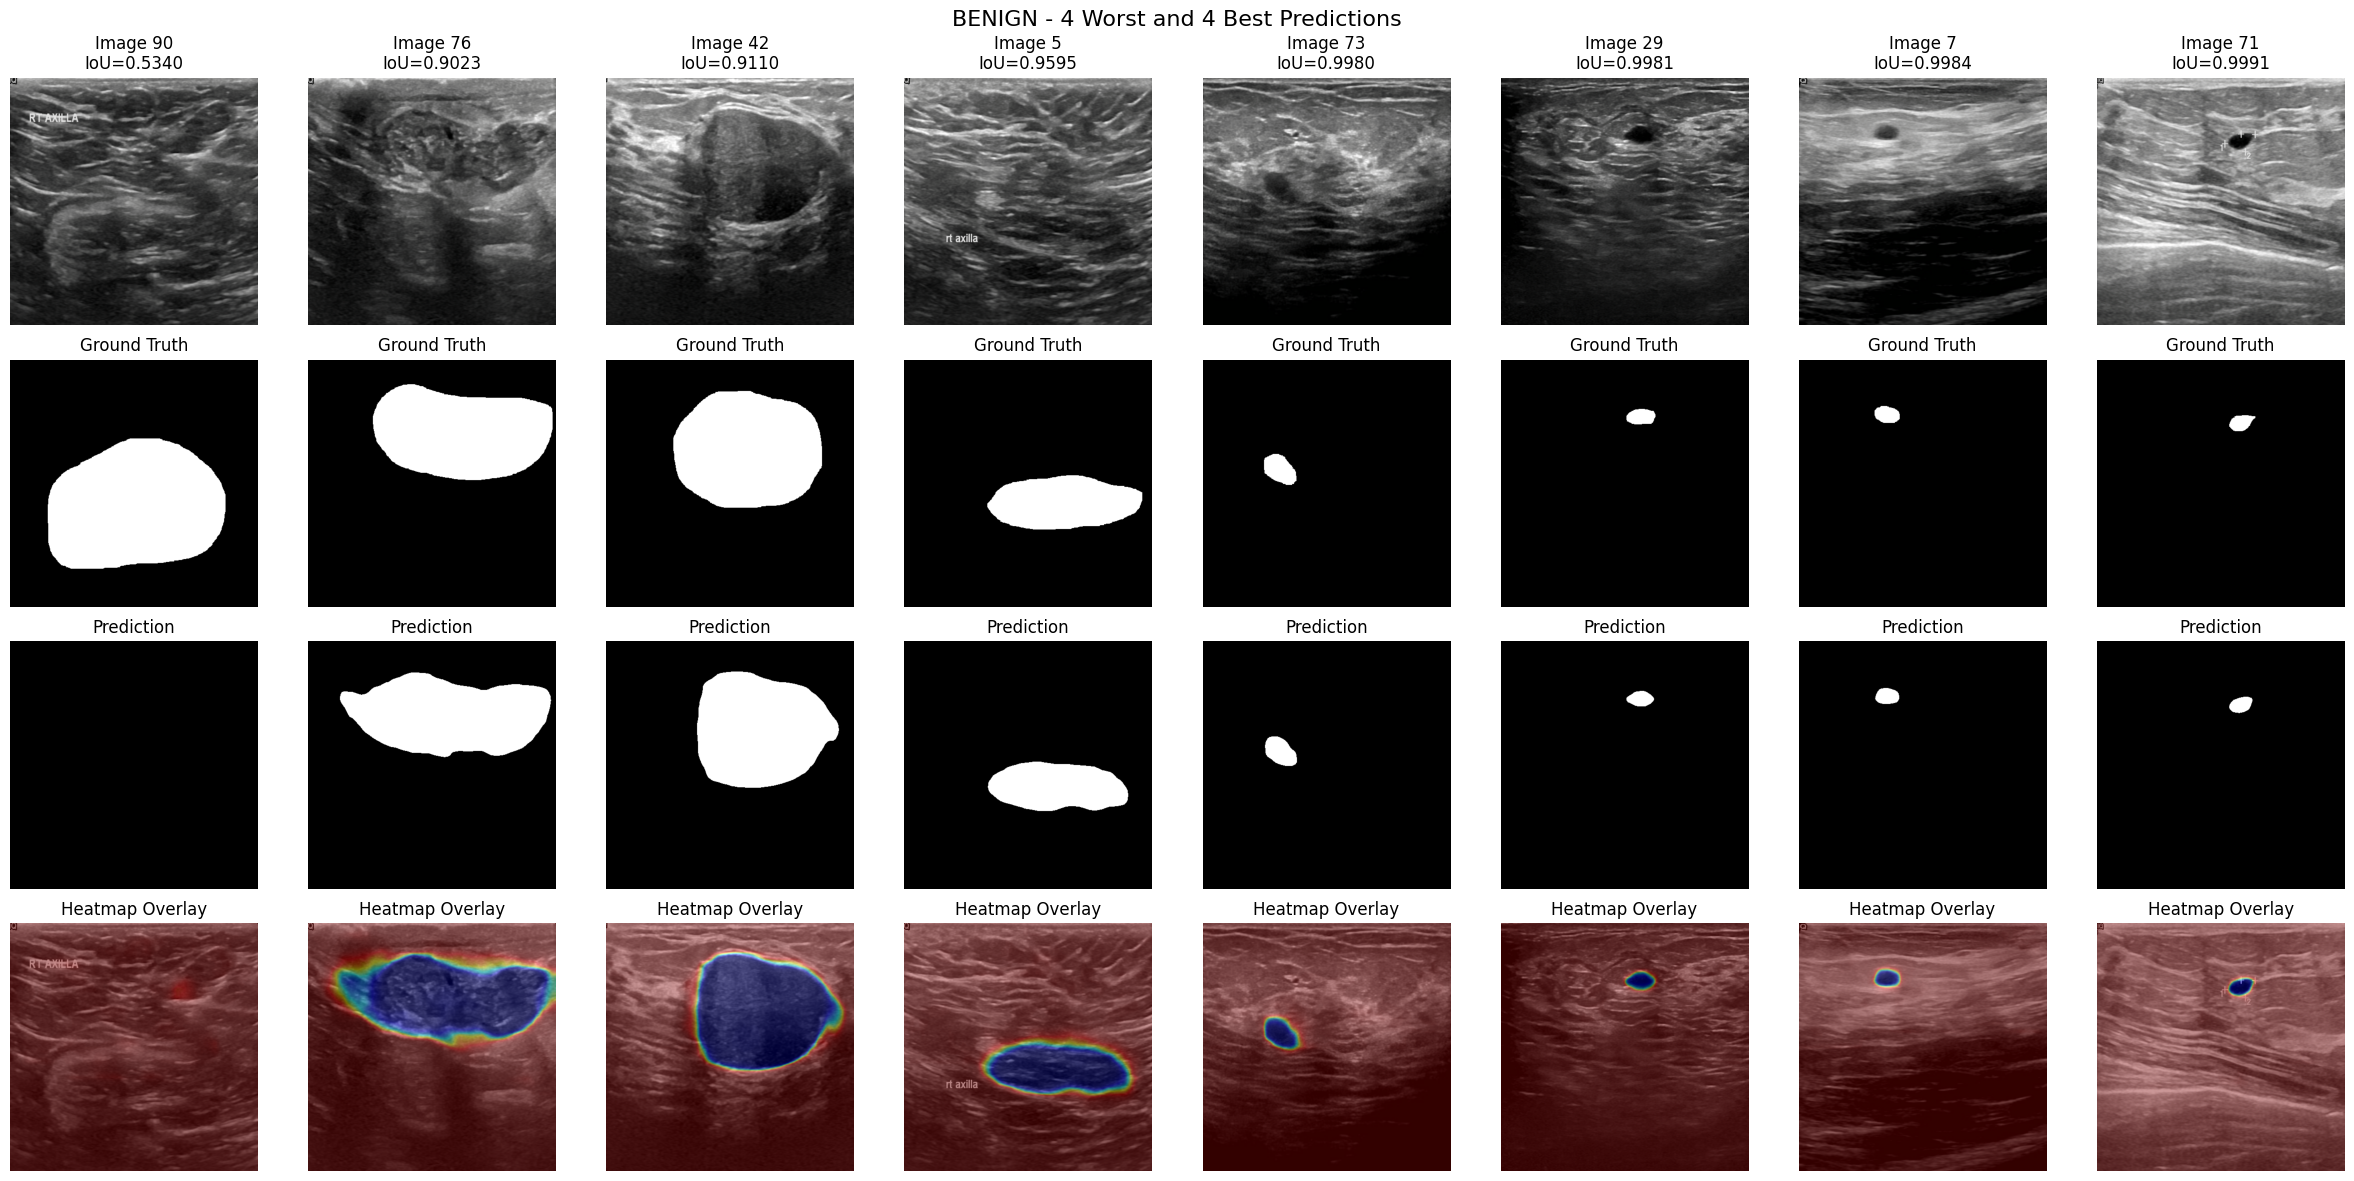

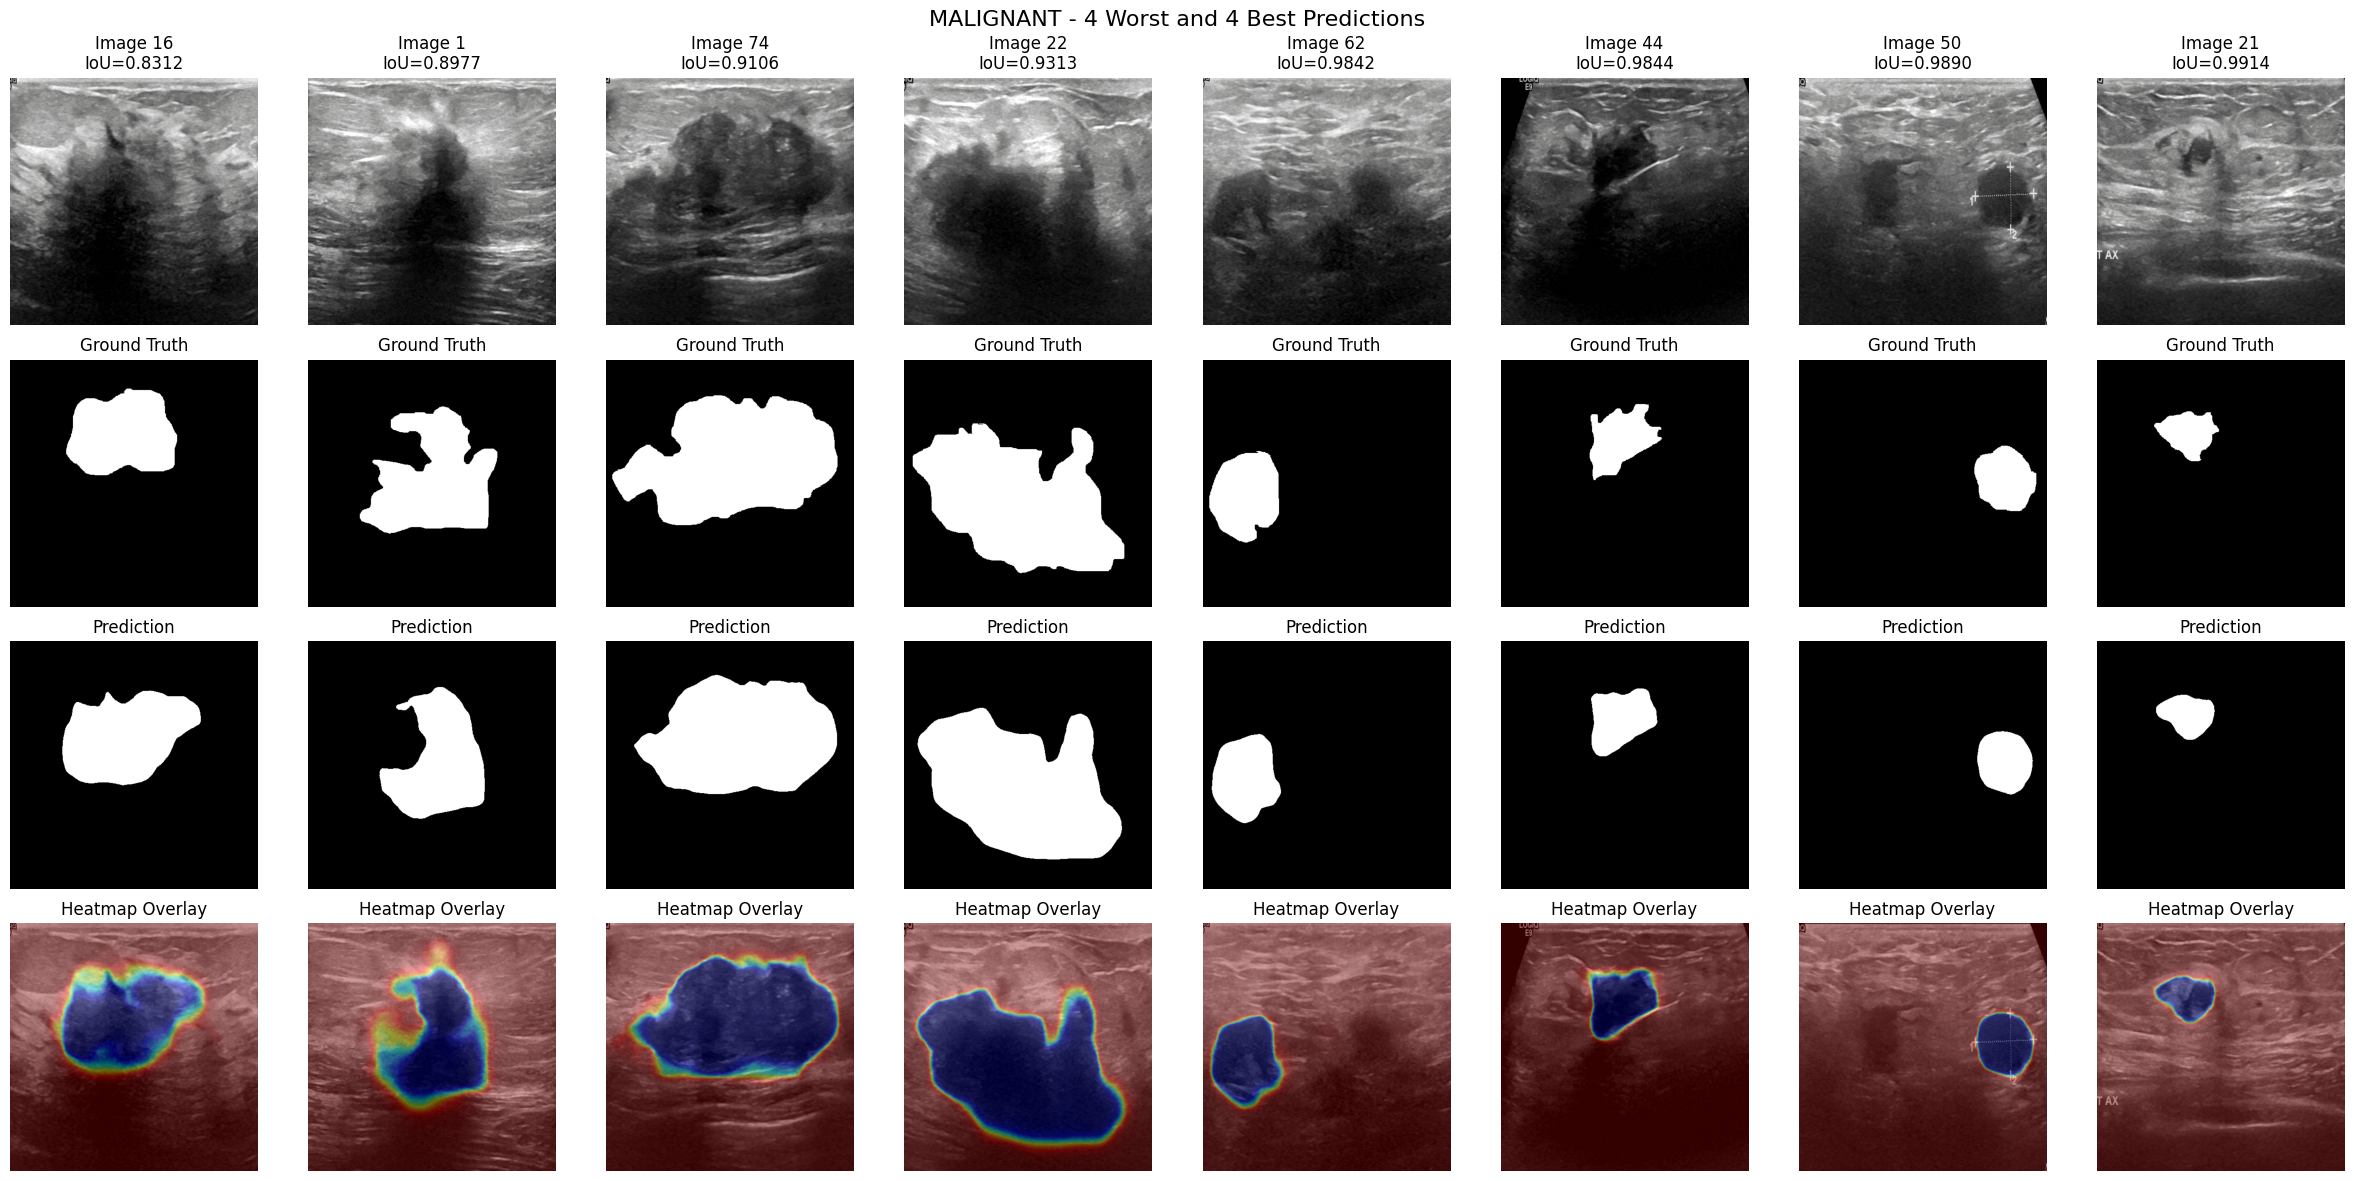

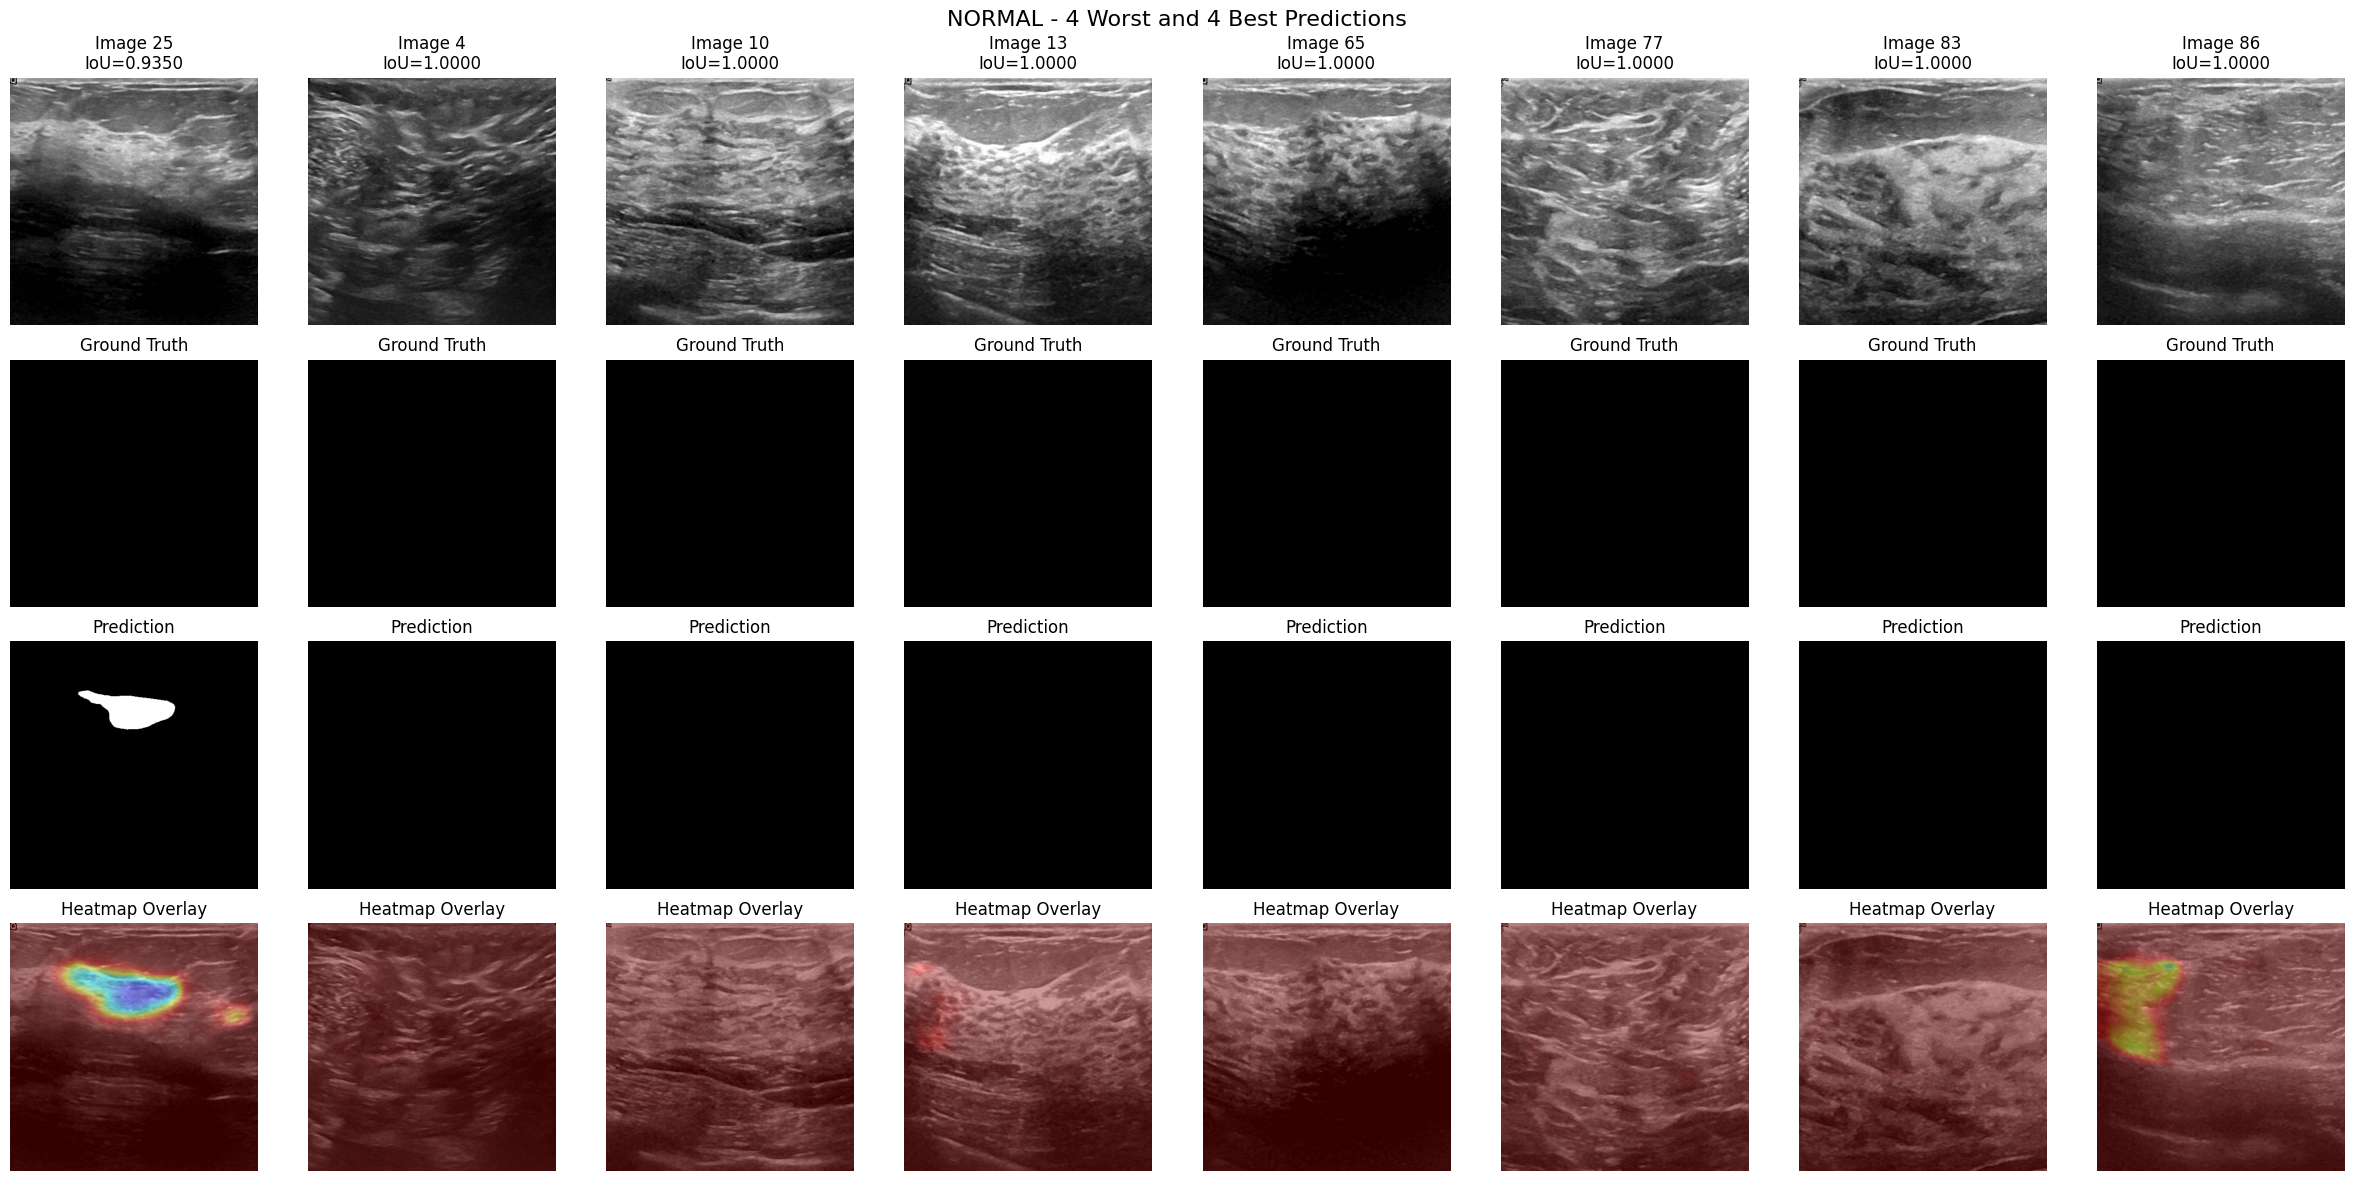

In [27]:
if do_train:
    model_pth = "/kaggle/working/saved_model/best.pt"
else:
    model_pth = "/kaggle/input/breast-cancer-ultrasound-segmentation-segformer/saved_model/best.pt"
pred_show_best_worst_per_label(model_pth, device, test_dataset, num_class, top_k=4)

In [28]:
len(test_dataset)

92